/venv/lora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


/venv/lora/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


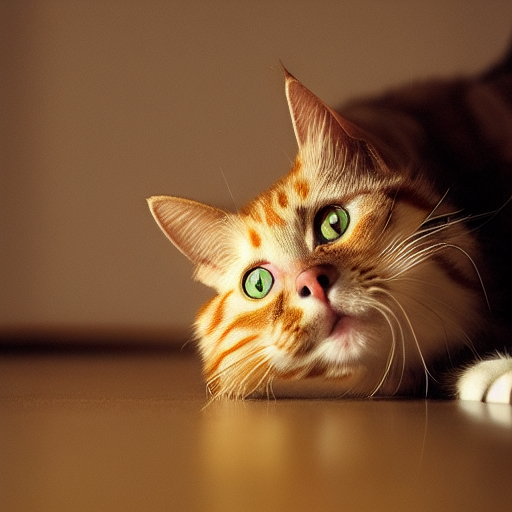

In [1]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = True

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A cat stretching on the floor, highly detailed, surrealism"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/dog.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [10]:
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)
for name, module in models["diffusion"].named_modules():
    print(name)



time_embedding
time_embedding.linear_1
time_embedding.linear_2
unet
unet.encoders
unet.encoders.0
unet.encoders.0.0
unet.encoders.1
unet.encoders.1.0
unet.encoders.1.0.groupnorm_feature
unet.encoders.1.0.conv_feature
unet.encoders.1.0.linear_time
unet.encoders.1.0.groupnorm_merged
unet.encoders.1.0.conv_merged
unet.encoders.1.0.residual_layer
unet.encoders.1.1
unet.encoders.1.1.groupnorm
unet.encoders.1.1.conv_input
unet.encoders.1.1.layernorm_1
unet.encoders.1.1.attention_1
unet.encoders.1.1.attention_1.in_proj
unet.encoders.1.1.attention_1.out_proj
unet.encoders.1.1.layernorm_2
unet.encoders.1.1.attention_2
unet.encoders.1.1.attention_2.q_proj
unet.encoders.1.1.attention_2.k_proj
unet.encoders.1.1.attention_2.v_proj
unet.encoders.1.1.attention_2.out_proj
unet.encoders.1.1.layernorm_3
unet.encoders.1.1.linear_geglu_1
unet.encoders.1.1.linear_geglu_2
unet.encoders.1.1.conv_output
unet.encoders.2
unet.encoders.2.0
unet.encoders.2.0.groupnorm_feature
unet.encoders.2.0.conv_feature
unet.

In [2]:
models = preload_models_with_lora(
    ckpt_path=model_file,
    device=DEVICE,
    lora_rank=4,
    lora_alpha=1.0,
    lora_dropout=0.0,
    apply_to_diffusion=True,
    apply_to_clip=False,
)
models = load_lora_into_models(models, "lora_weights.pt", device=DEVICE)

# 1) check LoRA modules exist
from lora import LoRALayer

for name, m in models["diffusion"].named_modules():
    if isinstance(m, LoRALayer):
        print("LoRA module:", name)

# 2) check LoRA parameters are non-zero
sd = models["diffusion"].state_dict()
for k, v in sd.items():
    if "lora_A" in k or "lora_B" in k:
        print(k, v.shape, v.abs().mean().item())


NameError: name 'preload_models_with_lora' is not defined

In [8]:
state = torch.load("lora_weights.pt", map_location="cpu")
print(state.keys())


dict_keys(['diffusion.unet.encoders.1.1.attention_1.in_proj.lora_A', 'diffusion.unet.encoders.1.1.attention_1.in_proj.lora_B', 'diffusion.unet.encoders.1.1.attention_1.in_proj.alpha', 'diffusion.unet.encoders.1.1.attention_1.in_proj.rank', 'diffusion.unet.encoders.1.1.attention_1.out_proj.lora_A', 'diffusion.unet.encoders.1.1.attention_1.out_proj.lora_B', 'diffusion.unet.encoders.1.1.attention_1.out_proj.alpha', 'diffusion.unet.encoders.1.1.attention_1.out_proj.rank', 'diffusion.unet.encoders.1.1.attention_2.q_proj.lora_A', 'diffusion.unet.encoders.1.1.attention_2.q_proj.lora_B', 'diffusion.unet.encoders.1.1.attention_2.q_proj.alpha', 'diffusion.unet.encoders.1.1.attention_2.q_proj.rank', 'diffusion.unet.encoders.1.1.attention_2.k_proj.lora_A', 'diffusion.unet.encoders.1.1.attention_2.k_proj.lora_B', 'diffusion.unet.encoders.1.1.attention_2.k_proj.alpha', 'diffusion.unet.encoders.1.1.attention_2.k_proj.rank', 'diffusion.unet.encoders.1.1.attention_2.v_proj.lora_A', 'diffusion.unet.enco

/venv/lora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


/venv/lora/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Applied LoRA to 96 layers
  - unet.encoders.1.1.attention_1.in_proj
  - unet.encoders.1.1.attention_1.out_proj
  - unet.encoders.1.1.attention_2.q_proj
  - unet.encoders.1.1.attention_2.k_proj
  - unet.encoders.1.1.attention_2.v_proj
  - unet.encoders.1.1.attention_2.out_proj
  - unet.encoders.2.1.attention_1.in_proj
  - unet.encoders.2.1.attention_1.out_proj
  - unet.encoders.2.1.attention_2.q_proj
  - unet.encoders.2.1.attention_2.k_proj
  - unet.encoders.2.1.attention_2.v_proj
  - unet.encoders.2.1.attention_2.out_proj
  - unet.encoders.4.1.attention_1.in_proj
  - unet.encoders.4.1.attention_1.out_proj
  - unet.encoders.4.1.attention_2.q_proj
  - unet.encoders.4.1.attention_2.k_proj
  - unet.encoders.4.1.attention_2.v_proj
  - unet.encoders.4.1.attention_2.out_proj
  - unet.encoders.5.1.attention_1.in_proj
  - unet.encoders.5.1.attention_1.out_proj
  - unet.encoders.5.1.attention_2.q_proj
  - unet.encoders.5.1.attention_2.k_proj
  - unet.encoders.5.1.attention_2.v_proj
  - unet.enco

100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


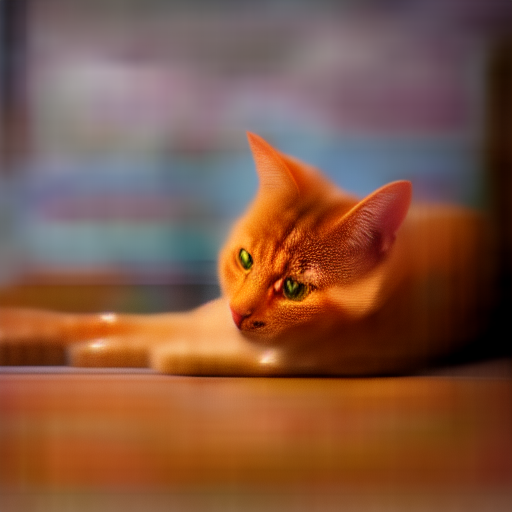

In [1]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

from model_loader import preload_models_with_lora
from lora import load_lora_weights
import torch.nn as nn

DEVICE = "cuda"

ALLOW_CUDA = True
ALLOW_MPS = True

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned.ckpt"
models = preload_models_with_lora(
    ckpt_path=model_file,
    device=DEVICE,
    lora_rank=4,
    lora_alpha=1.0,
    lora_dropout=0.0,
    apply_to_diffusion=True,
    apply_to_clip=False,
)

models = load_lora_weights(models, "lora_weights.pt")



## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A cat stretching on the floor, highly detailed, surrealism"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/dog.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)